# 🌍 DEM data for Virunga Volcanoes Massif, Rwanda 🌍

### Import libraries

In [30]:
import os
import pystac_client
import planetary_computer
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling, calculate_default_transform, transform_bounds
from rasterio.crs import CRS
from rasterio.errors import CRSError
from requests.exceptions import HTTPError
from functools import lru_cache
import warnings

In [31]:
# Supress warnings
warnings.filterwarnings("ignore")

### Define bounding box and target CRS

In [32]:
bbox = [29.339450987927847, -1.568347900000008, 
        29.706553166843705, -1.3332541178785493]
target_crs = "EPSG:4326"

### Create GeoJSON for the bbox

In [33]:
aoi_geojson = {
    "type": "Polygon",
    "coordinates": [[
        [bbox[0], bbox[1]],
        [bbox[2], bbox[1]],
        [bbox[2], bbox[3]],
        [bbox[0], bbox[3]],
        [bbox[0], bbox[1]]
    ]]
}

### Initialize STAC client

In [34]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)

### Search for DEM data

In [35]:
search = catalog.search(
    collections=["cop-dem-glo-30"],
    intersects=aoi_geojson,
    limit=None
)
items = list(search.get_all_items())
print(f"🔍 Found {len(items)} DEM items")

if not items:
    raise ValueError("No DEM items found for the given bbox")

# Get the first item
item = items[0]

🔍 Found 1 DEM items


### Cache signed URLs to avoid repeated API calls

In [36]:
@lru_cache(maxsize=None)
def get_signed_url(href):
    return planetary_computer.sign(href)

# Get signed URL for the DEM
if "data" not in item.assets:
    raise ValueError("The required 'data' key is missing in the item's assets")

signed_url = get_signed_url(item.assets["data"].href)

### Read source data and get properties

In [37]:
with rasterio.open(signed_url) as src:
    print(f"Source CRS: {src.crs}")
    
    if src.crs is None:
        raise ValueError("Source CRS is missing.")

    # Compute transformation
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *bbox
    )

    # Prepare output metadata
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'nodata': -9999,
        'dtype': 'float32',
        'driver': 'GTiff',
        'compress': 'lzw',
        'tiled': True
    })

    # Allocate memory for DEM
    dem = np.full((height, width), -9999, dtype=np.float32)

    # Reproject DEM
    reproject(
        source=rasterio.band(src, 1),
        destination=dem,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=target_crs,
        resampling=Resampling.bilinear
    )

print("✅ DEM reprojected successfully")


Source CRS: EPSG:4326
✅ DEM reprojected successfully


### Save the reprojected DEM as GeoTIFF

In [38]:
original_name = item.id
output_dir  = f"G:/Semester4/Innolab/eoAPI/data/dem/{original_name}"
output_filename = f"{output_dir}/{original_name}.tif"

# Create the folder if not already created
os.makedirs(output_dir, exist_ok=True)

# Save the reprojected DEM as GeoTIFF
with rasterio.open(output_filename, 'w', **kwargs) as dst:
    dst.write(dem, 1)
    dst.update_tags(
        TIFFTAG_RESOLUTIONUNIT='2',  # meters
        TIFFTAG_SOFTWARE='Python/Rasterio',
        AREA_OR_POINT='Point'
    )
print(f"✅ DEM saved as {output_filename}")

✅ DEM saved as G:/Semester4/Innolab/eoAPI/data/dem/Copernicus_DSM_COG_10_S02_00_E029_00_DEM/Copernicus_DSM_COG_10_S02_00_E029_00_DEM.tif


### Create coordinate arrays and meshgrid for plotting

In [39]:
x_coords = np.linspace(bbox[0], bbox[2], width)  # Longitudes
y_coords = np.linspace(bbox[3], bbox[1], height)  # Latitudes (reverse order)
X, Y = np.meshgrid(x_coords, y_coords)

# Mask no-data values (-9999) to avoid plotting them
masked_dem = np.ma.masked_equal(dem, -9999)

### Visualize DEM

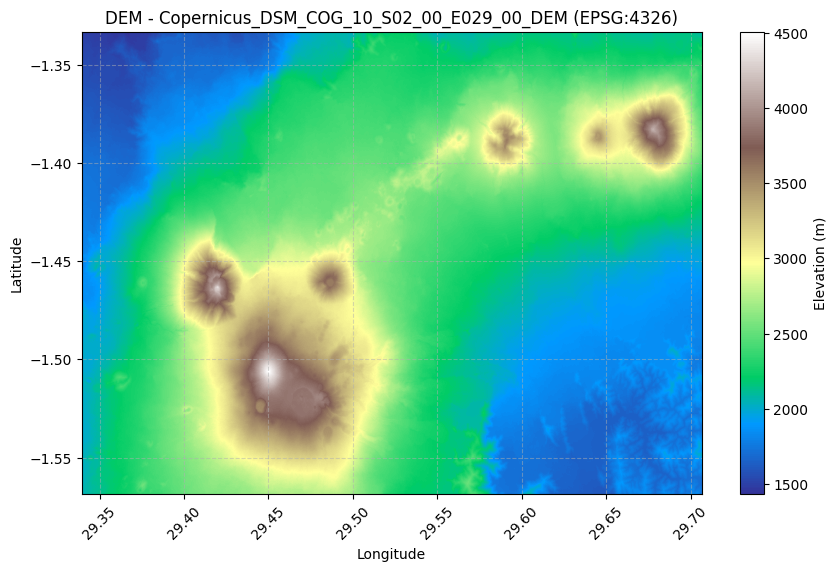

In [40]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(X, Y, masked_dem, cmap='terrain', shading='auto')

# Add colorbar and labels
plt.colorbar(label="Elevation (m)")
plt.title(f"DEM - {item.id} (EPSG:4326)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Format ticks properly
plt.xticks(rotation=45)
plt.gca().ticklabel_format(style="plain", axis="both", useOffset=False)
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()